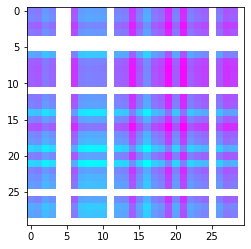

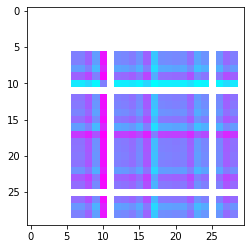

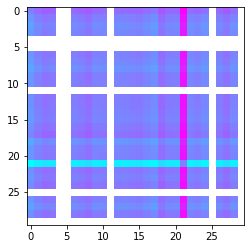

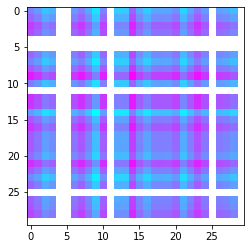

IndexError: index 4 is out of bounds for axis 0 with size 4

In [77]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_30.npy")

for i in range(10):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

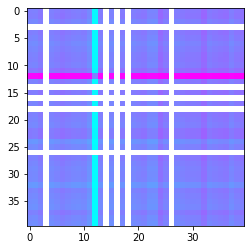

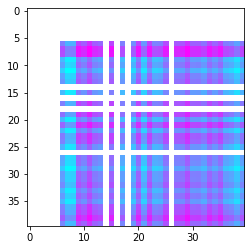

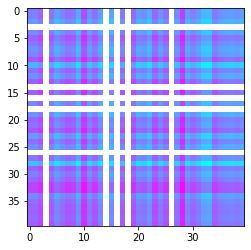

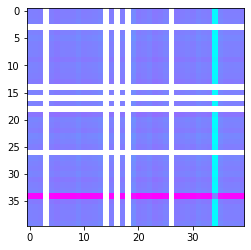

IndexError: index 4 is out of bounds for axis 0 with size 4

In [78]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_40.npy")

for i in range(10):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

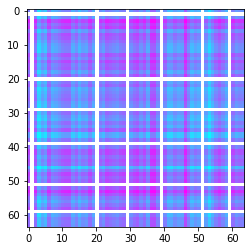

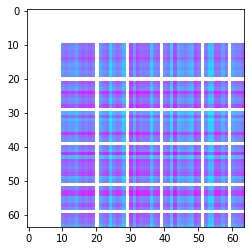

IndexError: index 2 is out of bounds for axis 0 with size 2

In [75]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_64.npy")

for i in range(10):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

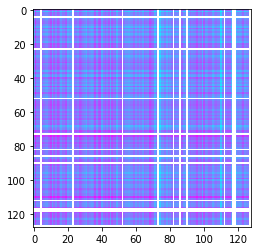

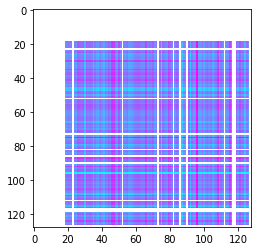

IndexError: index 2 is out of bounds for axis 0 with size 2

In [76]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_128.npy")

for i in range(10):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

In [ ]:
SIZE = 30

In [55]:
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    MTF_o = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(SIZE/2,SIZE/2))  
    MTF_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u%d_d%d.npy'%(SIZE/2,SIZE/2))  
    T_o = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/time_channel_%d.npy'%SIZE)  
    GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_%d.npy"%SIZE) #tambien se puede hacer inversa (trans)
    GASF = np.load("/work/work_teamEXOPLANET/GAF/GADF_%d.npy"%SIZE)
    
    #fill nan with??
    GADF = np.nan_to_num(GADF)
    GASF = np.nan_to_num(GASF)

    x_all = []
    for i in range(MTF_o.shape[0]):
        combined_image = np.dstack((MTF_o[i],GADF[i],GASF[i]))
        x_all.append(combined_image)
    x_all = np.asarray(x_all)
    print("shape:",x_all.shape)

    fold ="../../KOI_Data/"
    df_sets = pd.read_csv(fold+"/koi_sets.csv") 
    mask_train = (df_sets["Set"] == "Train").values
    mask_test = (df_sets["Set"] == "Test").values

    df_meta = pd.read_csv(fold+"/koi_metadata.csv")
    df_meta_train = df_meta[mask_train]
    df_meta_test = df_meta[mask_test]
    y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
    y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_val, counts_val = np.unique(y_val, return_counts=True)

    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    
    print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
    print ("Objetos de validación:",x_val.shape,y_val.shape)

    return x_train, y_train, x_val, y_val

In [56]:
x_train, y_train, x_val, y_val = data()

shape: (8054, 30, 30, 3)
Objetos de entrenamiento: (4339, 30, 30, 3) (4339,)
Objetos de validación: (1918, 30, 30, 3) (1918,)


In [68]:
import keras, os, sys
from keras.layers import *
from keras.models import *
from sklearn.metrics import f1_score

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from utils import binary_focal_loss

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return 
    
def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6):
    if focal:
        model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    metrics = Metrics()
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val),
                      callbacks=[metrics])
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    #plt.legend(loc="upper right")
    plt.show()
    
    print("Best f1 macro trough iters: ", np.max(metrics.val_f1s))

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [69]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [70]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 5s 1ms/step - loss: 0.6536 - acc: 0.6227 - val_loss: 0.5980 - val_acc: 0.6481
 - val_f1: 0.478820 
Epoch 2/200
4339/4339 [==============================] - 3s 772us/step - loss: 0.5992 - acc: 0.6209 - val_loss: 0.5713 - val_acc: 0.6559
 - val_f1: 0.615449 
Epoch 3/200
4339/4339 [==============================] - 3s 738us/step - loss: 0.5757 - acc: 0.6474 - val_loss: 0.5591 - val_acc: 0.6564
 - val_f1: 0.647972 
Epoch 4/200
4339/4339 [==============================] - 3s 694us/step - loss: 0.5631 - acc: 0.6402 - val_loss: 0.5492 - val_acc: 0.6637
 - val_f1: 0.589169 
Epoch 5/200
4339/4339 [==============================] - 3s 795us/step - loss: 0.5597 - acc: 0.6557 - val_loss: 0.5487 - val_acc: 0.6710
 - val_f1: 0.622591 
Epoch 6/200
4339/4339 [==============================] - 4s 826us/step - loss: 0.5507 - acc: 0.6601 - val_loss: 0.5439 - val_acc: 0.6747
 - val_f1: 0.643867 
Epoch 

KeyboardInterrupt: 